# Técnicas de Deep Learning de séries temporais na previsão de acidentes na cidade de braga

Com este trabalho pretendemos resolver um problema single-step multivariável, ou seja, através de uma conjunto de variáveis pretendemos prever o número de acidentes

Neste trabalho usamos uma série de biblioteca disponibilizadas pelo python de forma a simplificar a resolução do nosso problema

Biblioteca importadas:

pandas - manipulação de analise de dados            

numpy - implementação de vetores e matrizes 

tensorflow - machine learning package

sklearn - machine learning package

matplotlib - visualização e geração de graficos

sweetviz - Exploratory Data Analysis

autoviz - visualização e geração de graficos


In [243]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.preprocessing import OneHotEncoder
from datetime import date

#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91190530)
#for an easy reset backend session state
tf.keras.backend.clear_session()

Em primeiro lugar foi necessário ler os dados do ficheiro csv para isso criamos a função load_dataset() que permite através de um filepath ler os dados de um ficheiro para um pandas dataframe

In [244]:
#load dataset to pandas dataframe
def load_dataset(path):
  return pd.read_csv(path)

df = load_dataset("/content/drive/MyDrive/Traffic_Incidents_Braga_Until_20191231.csv")

# ANÁLISE EXPLORATÓRIA

Aqui começamos a realizar a exploração dos dados

In [245]:
'''INFORMAÇÕES GERAIS DO DATASET'''

#Quantidade de linhas e colunas do DataFrame
print(df.shape)

#dataset info
print(df.info())
print('-----------------FIM DF.INFO()-----------------')

(83347, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83347 entries, 0 to 83346
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city_name                83347 non-null  object 
 1   description              83347 non-null  object 
 2   cause_of_incident        426 non-null    object 
 3   from_road                83347 non-null  object 
 4   to_road                  83347 non-null  object 
 5   affected_roads           40981 non-null  object 
 6   incident_category_desc   83347 non-null  object 
 7   magnitude_of_delay_desc  83347 non-null  object 
 8   length_in_meters         83347 non-null  int64  
 9   delay_in_seconds         83347 non-null  int64  
 10  incident_date            83347 non-null  object 
 11  latitude                 83347 non-null  float64
 12  longitude                83347 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 8.3+ MB
None
--

Aqui realizamos um Group By

In [246]:
'''GROUP BY PARA EXPLORAR O DATASET
'''
df.groupby(['from_road', 'to_road']).size().reset_index(name='counts')

,from_road,to_road,counts
0,A11 exit [5],Rua Frei José Vilaça (N103),1
1,A11 exit [8],Vimieiro,1
2,"A11, Braga-Ferreiros (Braga-Circular)",Avenida General Norton De Matos (Braga-Circular),48
3,"A11, Braga-Ferreiros (Braga-Circular)",N101 (Braga Norte) (Braga-Circular),15
4,"A11, Braga-Ferreiros (Braga-Circular)",N103 (Ferreiros) (Braga-Circular),2
...,...,...,...
1557,Via da Falperra (N309),Via da Falperra (N309),3
1558,Washington St (US-41),IL-21 (Skokie Hwy/US-41),1
1559,exit [7],A11 exit [8],3
1560,Área De Portagem Braga-Ferreiros (A11),Braga-Circular (A11),2


Aqui utilizamos a bibloteca sweetviz que nos fornece um monte de informações acerca do dataset através de uma página HTML

In [247]:
'''EXPLORAÇÃO MAIS PROFUNDA DO DATASET - EM UMA PÁGINA HTML'''

analise = sv.analyze(df)
analise.show_html('DataExploration_Traffic_Incidents.html')

                                             |          | [  0%]   00:00 -> (? left)

Report DataExploration_Traffic_Incidents.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


A partir daqui realizamos alguns gráficos para termos uma visão melhor dos dados do dataset

Shape of your Data Set: (83347, 13)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  2
    Number of String-Categorical Columns =  3
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  4
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  2
    13 Predictors classified...
        This does not include the Target column(s)
        6 variables removed since they were ID or low-information variables
Number of All Scatter Plots = 3


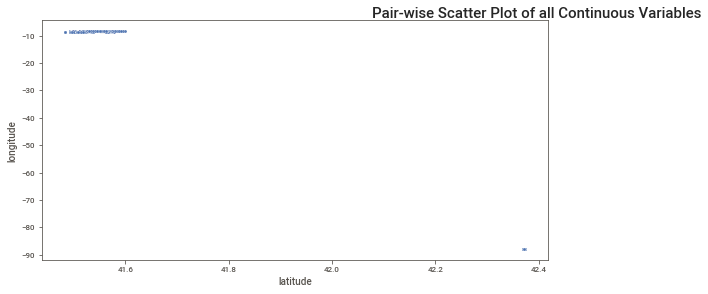

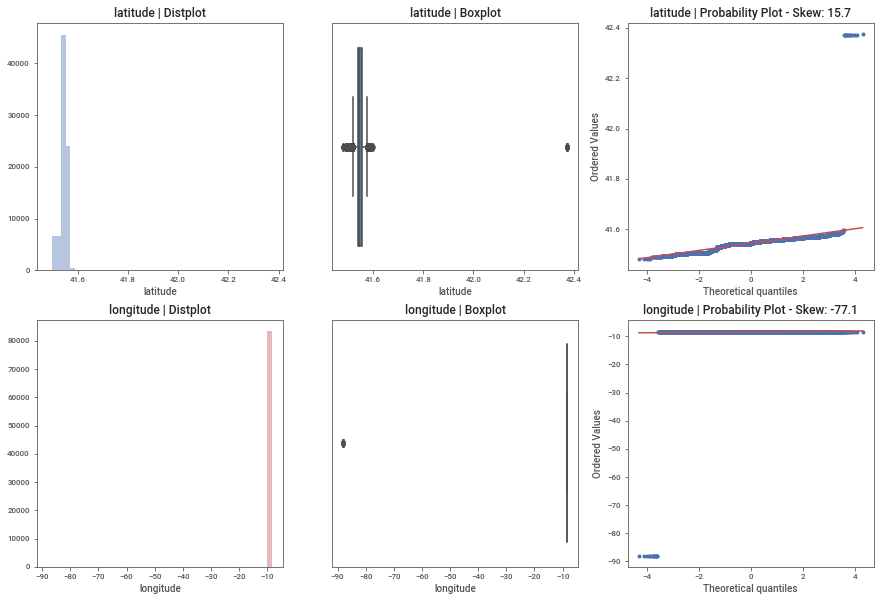

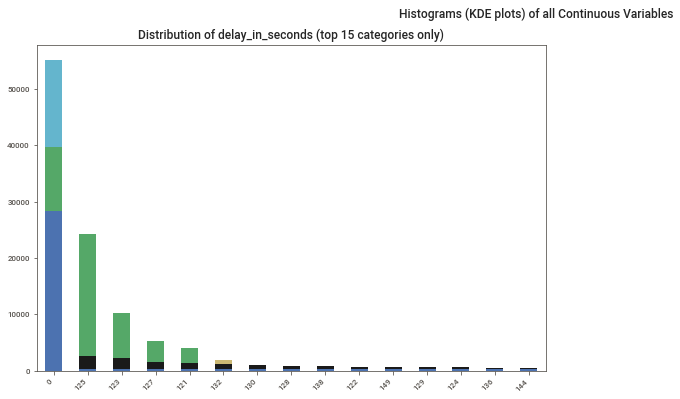

Could not draw Violin Plot


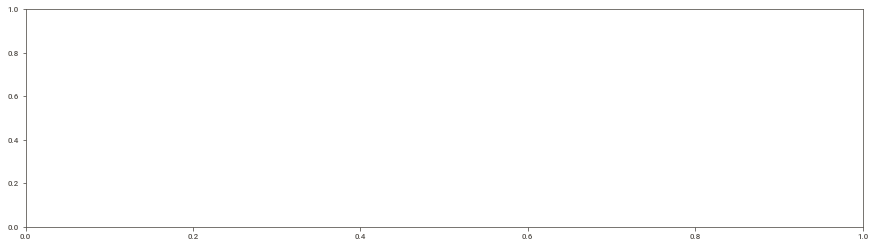

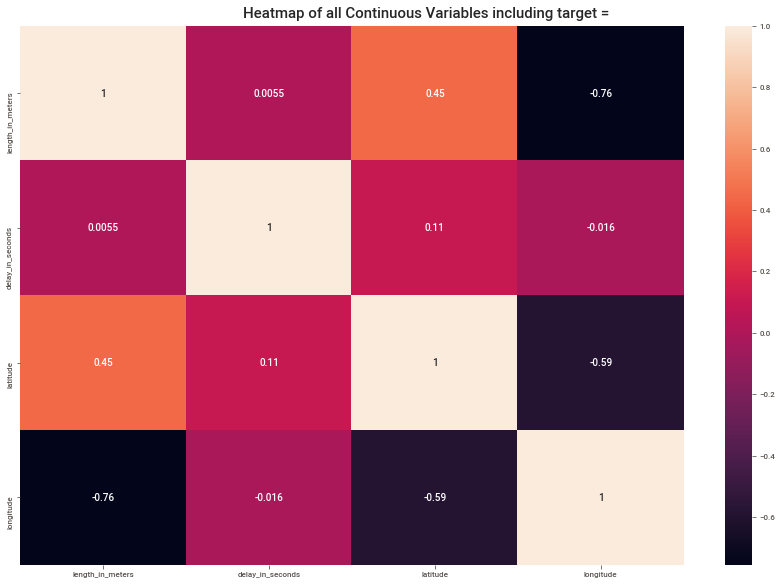

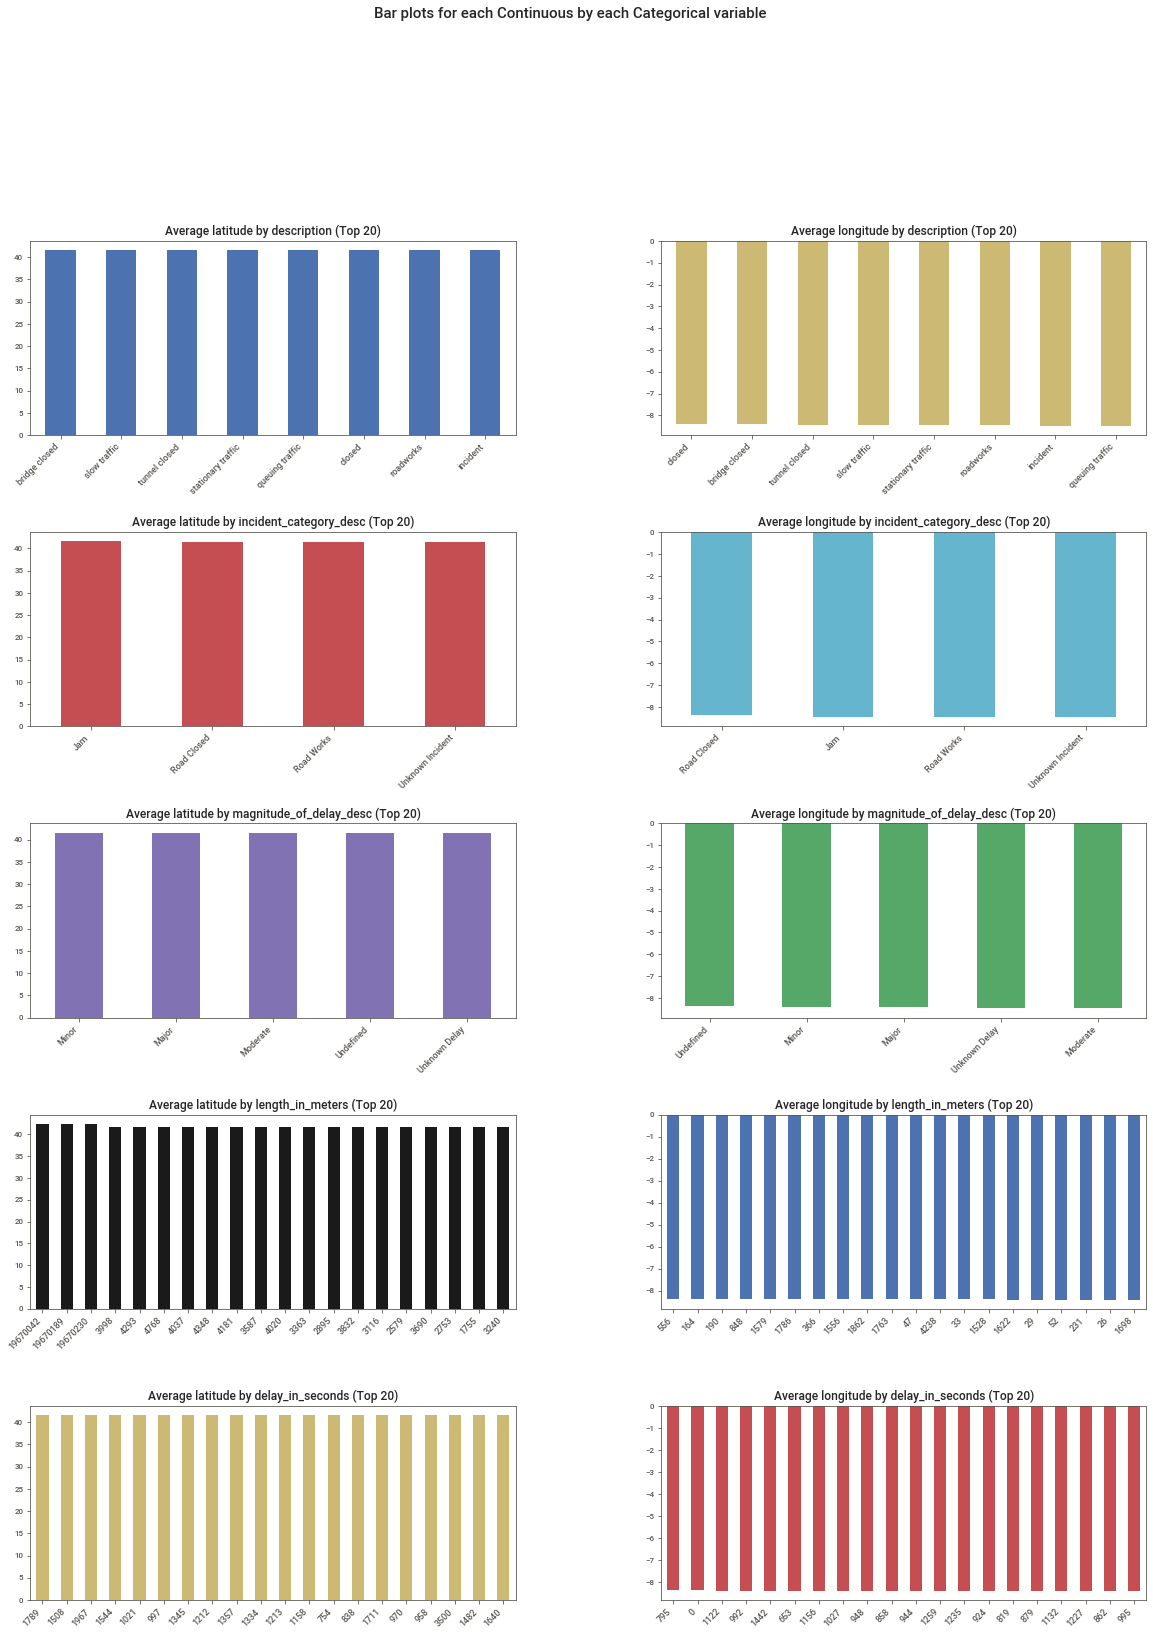

Time to run AutoViz (in seconds) = 4.803

 ###################### VISUALIZATION Completed ########################


,description,incident_category_desc,magnitude_of_delay_desc,length_in_meters,delay_in_seconds,latitude,longitude
0,queuing traffic,Jam,Moderate,615,111,41.537361,-8.452289
1,queuing traffic,Jam,Moderate,1008,210,41.531712,-8.440025
2,queuing traffic,Jam,Moderate,615,184,41.559666,-8.418733
3,stationary traffic,Jam,Major,322,232,41.557526,-8.417557
4,stationary traffic,Jam,Major,208,235,41.558880,-8.445529
...,...,...,...,...,...,...,...
83342,stationary traffic,Jam,Major,157,178,41.544969,-8.420512
83343,stationary traffic,Jam,Major,137,182,41.547453,-8.420823
83344,stationary traffic,Jam,Major,157,208,41.544969,-8.420512
83345,stationary traffic,Jam,Major,157,209,41.544969,-8.420512


In [248]:
'''ALGUNS GRAFICOS GERAIS DO DATASET'''

AV = AutoViz_Class()
AV.AutoViz ('/content/drive/MyDrive/Traffic_Incidents_Braga_Until_20191231.csv')

# Tratamento de Dados

Começamos por separar a data e a hora no nosso tratamento de dados

In [249]:
''' SEPARAR DATA E HORA '''

division_incident_date = df['incident_date'].str.split('.')
#print(division_incident_date.head())

date = division_incident_date.str.get(0)
df['date'] = date
df = df.drop(columns=['incident_date'])
#print(division_incident_date.head())

division_date_hour = df['date'].str.split(' ')
incident_date = division_date_hour.str.get(0)
incident_hour = division_date_hour.str.get(1)
df['incident_date'] = incident_date 
df['incident_hour'] = incident_hour
df['incident_date1'] = incident_date 

Aqui apagamos colunas que não nos interessavam

In [250]:
'''APAGAR COLUNAS'''
df = df.drop(columns=['city_name'])
df = df.drop(columns=['cause_of_incident'])
df = df.drop(columns=['from_road'])
df = df.drop(columns=['to_road'])
df = df.drop(columns=['affected_roads'])
df = df.drop(columns=['date'])
df = df.drop(columns=['longitude'])
df = df.drop(columns=['latitude'])
df = df.drop(columns=['description'])
df = df.drop(columns=['magnitude_of_delay_desc'])
df = df.drop(columns=['incident_category_desc'])
'''RESET INDEX'''

df = df.reset_index(drop=True)

Aqui realizmos um bin das horas

In [251]:
'''BINS'''

#%H - Hora (relógio de 24 horas) como um número decimal preenchido com zero.
#%M - Minuto como um número decimal preenchido com zero.
#%S - Em segundo lugar, como um número decimal preenchido com zero.
#%f - Microssegundo como um número decimal, preenchido com zeros à esquerda.
# df['quantile_ex_1'] = pd.qcut(df['ext price'], q=4)

hours = pd.to_datetime(df['incident_hour'], format='%H:%M:%S').dt.hour
df['incident_hour_bins'] = pd.cut(hours, 
                    bins=[0,6,9,11,14,17,19,21,24],
                    ordered=False, 
                    include_lowest=True, 
                    labels=['7-Noite', '1-Hora de Ponta Manha', '2-Meio da Manha', '3-Hora de Ponta Almoco', '4-Meio da Tarde', '5-Hora de Ponta Noite', '6-Final do Dia', '7-Noite'])
                    
                    #7-10 Hora de ponta Manha
                    #10-12 Meio da Manha
                    #12-15 Hora de ponta Almoço
                    #15-18 Meio da Tarde
                    #18-20 Hora de ponta noite
                    #20-22 Final do Dia
                    #22-7 Noite

                    # Agrupar por hora e data

Aqui criamos um group by com as variáveis que nos interessavam

In [252]:
'''Group By contar acidentes'''

Contagem = df.groupby(['incident_date','incident_hour_bins']).size().reset_index(name='counts')
Teste = df.groupby(['incident_date','incident_hour_bins']).agg({'delay_in_seconds': ['mean'], 'length_in_meters': 'mean'})

df = pd.merge(Contagem, Teste, on=('incident_date', 'incident_hour_bins'))

Por último realizamos o One Hot Encoding do bin das horas que criamos

In [253]:
'''One Hot Encoding'''

'''Horas'''
df['incident_hour'] = df['incident_hour_bins'].replace({'Hora de Ponta Manha': '1Hora de Ponta Manha', 'Meio da Manha': '2Meio da Manha', 'Hora de Ponta Almoco': '3Hora de Ponta Almoco', 'Meio da Tarde': '4Meio da Tarde', 'Hora de Ponta Noite': '5Hora de Ponta Noite', 'Final do Dia': '6Final do Dia', 'Noite': '7Noite'})

df = df.drop(columns=['incident_hour_bins'])

#Create the OneHotEncoder Object
onehotencoder = OneHotEncoder (sparse=False,handle_unknown='error')

#Perform OneHotEncoding
onehotencoder_df = pd.DataFrame(onehotencoder.fit_transform(df[['incident_hour']]))
df = df.join(onehotencoder_df)
df = df.drop(columns=['incident_hour'])
mapping = {df.columns[4]:'Hora de Ponta Manha', df.columns[5]:'Meio da Manha', df.columns[6]:'Hora de Ponta Almoco', df.columns[7]:'Meio da Tarde', df.columns[8]: 'Hora de Ponta Noite', df.columns[9]: 'Final do Dia', df.columns[10]: 'Noite'}
df = df.rename(columns=mapping)
df = df.drop(columns=['incident_date'])

Consequentemente normalizamos os dados para o intervalo [-1,1] de modo a termos todos os atributos na mesma escala

In [254]:
#convert data to the same scale, in this problem is useless because we just have 1 atribute
def data_normalization(df, norm_range=(0, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  scaler.fit_transform(df)
  return scaler

scaler = data_normalization(df)
df=scaler.fit_transform(df)

# Criação da janela temporal

Agora como estamos a tratar um problema de séries temporais, é  necesssário criar uma janela temporal para cada elemento do dataset, ou seja, é necessário para cada elemento guardar os k elementos anteriores

Exemplificando: Com esta lista de inteiros [1,2,3,4,5,6,7,8] caso o número de timesteps k seja 4 por janela

[1,2,3,4]

[2,3,4,5]

[3,4,5,6] 

[4,5,6,7] 

[5,6,7,8]   



Aqui foi necessário criar 3 funçoes diferentes para a criação das janelas pois cada uma é usada para obter dados para diferentes previsões: count, length_in_meters e delay_in_seconds


In [255]:
#build time series windows and split in predictores and labels
#return count in label

def to_supervised_count(df, timesteps):
  data = df
  atributes=df[:,[1,2,3,4,5,6,7,8,9]]
  labels=df[:,0]
  x, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      x.append(atributes[curr_pos:input_index])
      y.append(labels[input_index:label_index])  
  #using np.float32 for GPU performance

  x_count=np.array(x).astype('float32')
  where_are_NaNs = np.isnan(x_count)
  x_count[where_are_NaNs] = 0

  y_count=np.array(y).astype('float32')
  where_are_NaNs = np.isnan(y_count)
  y_count[where_are_NaNs] = 0

  return x_count, y_count

  #build time series windows and split in predictores and labels
#return count in label

def to_supervised_delay(df, timesteps):
  data = df
  atributes=df[:,[0,2,3,4,5,6,7,8,9]]
  labels=df[:,1]
  x, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      x.append(atributes[curr_pos:input_index])
      y.append(labels[input_index:label_index])  
  #using np.float32 for GPU performance
  x_delay=np.array(x).astype('float32')
  where_are_NaNs = np.isnan(x_delay)
  x_delay[where_are_NaNs] = 0

  y_delay=np.array(y).astype('float32')
  where_are_NaNs = np.isnan(y_delay)
  y_delay[where_are_NaNs] = 0

  return x_delay, y_delay

def to_supervised_meters(df, timesteps):
  data = df
  atributes=df[:,[0,1,3,4,5,6,7,8,9]]
  labels=df[:,2]
  x, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      x.append(atributes[curr_pos:input_index])
      y.append(labels[input_index:label_index])  
  #using np.float32 for GPU performance
  x_meters=np.array(x).astype('float32')
  where_are_NaNs = np.isnan(x_meters)
  x_meters[where_are_NaNs] = 0

  y_meters=np.array(y).astype('float32')
  where_are_NaNs = np.isnan(y_meters)
  y_meters[where_are_NaNs] = 0

  return x_meters, y_meters

De modo a criarmos os modelos de previsão definimos três funções que permitem definir os modelos.

Implementamos duas funçoes que criam RNN (LSTM e GRU) e uma que cria uma CNN.
Todas elas utilizam o método de aprendizagem Adam com a mae como loss function

In [256]:
#define the DL models
def build_lstm(timesteps, h_neurons=64 ,features=9):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons,activation='relu', return_sequences=True,  input_shape=(timesteps,features)))
  model.add(tf.keras.layers.LSTM(h_neurons,activation='relu'))
  model.add(tf.keras.layers.Dense(units=32, activation='relu')),
  model.add(tf.keras.layers.Dense(1))
  #compile
  model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = 'mae')
  return model

def build_gru(timesteps, h_neurons=64 ,features=9):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GRU(h_neurons,activation='relu', return_sequences=True,  input_shape=(timesteps,features)))
  model.add(tf.keras.layers.GRU(h_neurons,activation='relu'))
  model.add(tf.keras.layers.Dense(units=32, activation='relu')),
  model.add(tf.keras.layers.Dense(1))
  #compile
  model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = 'mae')
  return model

def build_cnn(timesteps,features=9,filters=16, kernel_size=5, pool_size=2):
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,activation='relu', data_format='channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size=pool_size,data_format='channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(), metrics = 'mae')
  return model

De seguida definimos funçoes capazes de treinar e realizar a previsão dos modelos

Em primeiro lugar criamos um função, split_data(), para separar 10% dos dados de treino para validação.

Também criamos uma função fit() capaz de treinar e que devolve o modelo treinado, a evolução do seu desempenho ao longo do treino e também a avaliação do modelo no dataset de teste

Para além disso definimos duas funções, uma para realizar previsões sobre o modelo (predict) e para realizar previsões sobre o modelo apartir do ultimo elemento do dataset de treino (forecast). Relativamente ao forescast, temos aqui uma operação um pouco mais complexa pois para prevermos recursivamente o count, tivemos tambem de prever o delay_in_seconds e o length_in_meters pois estes dois atributos são necessários para a previsão do count




In [257]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

#train DL model with train dataset and evaluate with test dataset
#return model and performance
def fit(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size):
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
  epochs=epochs, batch_size=batch_size, shuffle=False)
  metrics = model.evaluate(X_test, y_test)
  hist_list=history
  loss=metrics[1]

  return model, hist_list, loss

#predict the next step of sequence
def predict(model, X_test):
    return  model.predict(X_test)[:, 0][..., np.newaxis]

def get_part_day(x):
  part_day=np.split(x, [2])[1]
  if np.argmax(part_day)== 6: return 0
  return np.argmax(part_day)+1

#predict the next 30 days  since the last train dataset element
def forecast(model_count,model_meters,model_delay,x_count, x_meters, x_delay,timesteps):
  inp_count = x_count[1,-timesteps:,:] #getting the last sequence of known value
  inp_meters = x_meters[1,-timesteps:,:] #getting the last sequence of known value
  inp_delay = x_delay[1,-timesteps:,:] #getting the last sequence of known value
  next_days = []
  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, 30+1):
      inp_count=inp_count.reshape(1,timesteps,9)
      inp_meters=inp_meters.reshape(1,timesteps,9)
      inp_delay=inp_delay.reshape(1,timesteps,9)
      

      y_count= model_count.predict(inp_count)
      y_meters= model_meters.predict(inp_meters)
      y_delay= model_delay.predict(inp_delay)
      
      next_days.append(y_count)

      part_day=get_part_day(x_count)
      x_count = np.array([y_meters[0][0], y_delay[0][0], 0, 0, 0, 0, 0 , 0 , 0])
      x_meters = np.array([y_count[0][0], y_delay[0][0], 0, 0, 0, 0, 0 , 0 , 0])
      x_delay = np.array([y_count[0][0], y_meters[0][0], 0, 0, 0, 0, 0 , 0 , 0])
      
      x_count[2+part_day]=1
      x_meters[2+part_day]=1
      x_delay[2+part_day]=1


      inp_count=np.vstack([inp_count[0],x_count])
      inp_meters=np.vstack([inp_meters[0],x_meters])
      inp_delay=np.vstack([inp_delay[0],x_delay])
      
      inp_count=inp_count[-timesteps:]
      inp_meters=inp_meters[-timesteps:]
      inp_delay=inp_delay[-timesteps:]
  return np.reshape(next_days,(len(next_days),1))

Agora, realizamos a otimização de hiper-parametros dos modelos.

Para os modelos com LSTM e GRU, otimizamos o numero de neuronios, o numero de timesteps e o batchsize. 

Já na CNN otimizamos o número de timesteps e o batchsize.


In [ ]:
#lstm otimization, find the best hiperr-parameters like batch_size, timesteps and h_neurons
epochs=10
lstm_best_params=[]
for timesteps in range(5,11):
  x, y = to_supervised_count(df, timesteps)
  print("Training shape:", x.shape)
  print("Training labels shape:", y.shape)
  
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=3)
  for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

  X_train_count, y_train_count = x[train_idx], y[train_idx]
  X_val_count, y_val_count = x[val_idx], y[val_idx]
  X_test_count, y_test_count = x[test_index], y[test_index]

  for batch_size in [7,14,21]:
    for h_neurons in [64,128,256]:
      model=build_lstm(timesteps, h_neurons)
      lstm, hist_lstm, loss_lstm = fit(model,X_train_count, y_train_count, X_val_count, y_val_count, X_test_count, y_test_count, epochs, batch_size) 
      lstm_best_params.append("Timesteps %d - Batch_size %d - H_neurons %d - Score - %d" % (timesteps, batch_size, h_neurons,loss_lstm))

    
print(lstm_best_params)

In [ ]:
#gru otimization, find the best hiper-parameters like batch_size, timesteps and h_neurons
epochs=10
gru_best_params=[]
for timesteps in range(5,11):
  x, y = to_supervised_count(df, timesteps)
  print("Training shape:", x.shape)
  print("Training labels shape:", y.shape)
  
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=3)
  for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

  X_train_count, y_train_count = x[train_idx], y[train_idx]
  X_val_count, y_val_count = x[val_idx], y[val_idx]
  X_test_count, y_test_count = x[test_index], y[test_index]
  
  for batch_size in [7,14,21]:
    for h_neurons in [64,128,256]:
      model=build_gru(timesteps, h_neurons)
      gru, hist_gru, loss_gru= fit(model,X_train_count, y_train_count, X_val_count, y_val_count, X_test_count, y_test_count, epochs, batch_size) 
      gru_best_params.append("Timesteps %d - Batch_size %d - H_neurons %d - Score - %d" % (timesteps, batch_size, h_neurons,loss_gru))
   
print(gru_best_params)

In [ ]:
#cnn otimization, find the best hiper-parameters like batch_size, timesteps 
epochs=1
cnn_best_params=[]
for timesteps in range(5,11):
  x, y = to_supervised_count(df, timesteps)
  print("Training shape:", x.shape)
  print("Training labels shape:", y.shape)
  
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=3)
  for train_index, test_index in tscv.split(x): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

  X_train_count, y_train_count = x[train_idx], y[train_idx]
  X_val_count, y_val_count = x[val_idx], y[val_idx]
  X_test_count, y_test_count = x[test_index], y[test_index]
  
  for batch_size in [7,15,21]:
    model=build_cnn(timesteps)
    cnn, hist_cnn, loss_cnn = fit(model,X_train_count, y_train_count, X_val_count, y_val_count, X_test_count, y_test_count, epochs, batch_size) 
    cnn_best_params.append("Timesteps %d - Batch_size %d - H_neurons %d - Score - %d" % (timesteps, batch_size, h_neurons,loss_cnn))
 
print(cnn_best_params)

Agora que obtivemos os hiper-parametros, vamos treinar os 3 modelos com os mesmos, prever-los e realizar o forecast para os próximos 30 dias. Por cada um destes 3 modelos, foi necessário criar mais dois de forma a criar um modelo que permitisse prever o delay_in_seconds e o length_in_meters que serão necessário para o forecast

Training shape: (2045, 5, 9)
Training labels shape: (2045, 1)
Epoch 1/20
11/11 [==============================] - 3s 113ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0619 - val_mae: 0.0619
Epoch 2/20
11/11 [==============================] - 1s 80ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0617 - val_mae: 0.0617
Epoch 3/20
11/11 [==============================] - 1s 79ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0609 - val_mae: 0.0609
Epoch 4/20
11/11 [==============================] - 1s 82ms/step - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0590 - val_mae: 0.0590
Epoch 5/20
11/11 [==============================] - 1s 81ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0576 - val_mae: 0.0576
Epoch 6/20
11/11 [==============================] - 1s 82ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0562 - val_mae: 0.0562
Epoch 7/20
11/11 [==============================] - 1s 80ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0554 - val_mae: 0.0554
Epoch 8/20
11/11 [==

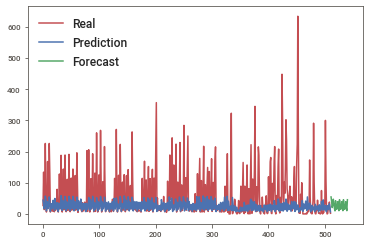

In [260]:
#fit, predict and forecast lstm with best params
timesteps=5
h_neurons=256
batch_size=128
epochs=20

x_count, y_count = to_supervised_count(df, timesteps)
x_meters, y_meters = to_supervised_meters(df, timesteps)
x_delay, y_delay = to_supervised_delay(df, timesteps)

print("Training shape:", x_count.shape)
print("Training labels shape:", y_count.shape)

#Time Series Cross Validator
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(x_count): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

X_count_train, y_count_train = x_count[train_idx], y_count[train_idx]
X_count_val, y_count_val = x_count[val_idx], y_count[val_idx]
X_count_test, y_count_test = x_count[test_index], y_count[test_index]

X_meters_train, y_meters_train = x_meters[train_idx], y_meters[train_idx]
X_meters_val, y_meters_val = x_meters[val_idx], y_meters[val_idx]
X_meters_test, y_meters_test = x_meters[test_index], y_meters[test_index]

X_delay_train, y_delay_train = x_delay[train_idx], y_delay[train_idx]
X_delay_val, y_delay_val = x_delay[val_idx], y_delay[val_idx]
X_delay_test, y_delay_test = x_delay[test_index], y_delay[test_index]

lstm_count = build_lstm(timesteps,h_neurons)
lstm_count, hist_lstm_count, loss_lstm_count = fit(lstm_count,X_count_train, y_count_train, X_count_val, y_count_val, X_count_test, y_count_test, epochs, batch_size) 

lstm_delay = build_lstm(timesteps,h_neurons)
lstm_delay, hist_lstm_delay, loss_lstm_delay = fit(lstm_delay,X_delay_train, y_delay_train, X_delay_val, y_delay_val, X_delay_test, y_delay_test, epochs, batch_size) 

lstm_meters = build_lstm(timesteps,h_neurons)
lstm_meters, hist_lstm_meters, loss_lstm_meters = fit(lstm_meters,X_meters_train, y_meters_train, X_meters_val, y_meters_val, X_meters_test, y_meters_test, epochs, batch_size) 

y_count_pred = predict(lstm_count, X_count_test) 
y_meters_pred = predict(lstm_meters, X_meters_test)
y_delay_pred = predict(lstm_delay, X_delay_test) 

next_days=forecast(lstm_count,lstm_meters,lstm_delay,x_count, x_meters, x_delay,timesteps)

scale = MinMaxScaler(feature_range=(0,1))
scale.min_, scale.scale_=scaler.min_[0],scaler.scale_[0]


y_count_test = scale.inverse_transform(y_count_test)
y_count_pred = scale.inverse_transform(y_count_pred)
next_days = scale.inverse_transform(next_days)

plt.plot(range(len(y_count_test)),y_count_test,"r-", label="Real")
plt.plot(range(len(y_count_pred)), y_count_pred, "b-",label="Prediction")
plt.plot(range(len(y_count_pred),len(y_count_pred)+len(next_days)), next_days, "g-",label="Forecast")
plt.legend(fontsize=12)
plt.savefig('lstm_graph')
plt.show()

Training shape: (2042, 8, 9)
Training labels shape: (2042, 1)
Epoch 1/200
66/66 [==============================] - 6s 50ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/200
66/66 [==============================] - 3s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/200
66/66 [==============================] - 3s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/200
66/66 [==============================] - 3s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/200
66/66 [==============================] - 3s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/200
66/66 [==============================] - 3s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/200
66/66 [==============================] - 3s 43ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/200
66/66 [==============================] - 3s 44ms/step - loss: nan - mae: nan - val_los

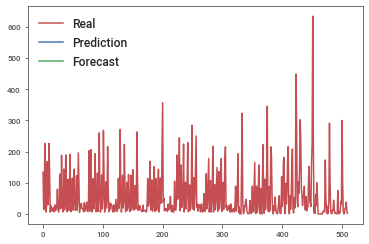

In [ ]:
#fit, predict and forecast gru with best params
timesteps=8
h_neurons=256
batch_size=21
epochs=200

x_count, y_count = to_supervised_count(df, timesteps)
x_meters, y_meters = to_supervised_meters(df, timesteps)
x_delay, y_delay = to_supervised_delay(df, timesteps)
print("Training shape:", x_count.shape)
print("Training labels shape:", y_count.shape)

#Time Series Cross Validator
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(x_count): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

X_count_train, y_count_train = x_count[train_idx], y_count[train_idx]
X_count_val, y_count_val = x_count[val_idx], y_count[val_idx]
X_count_test, y_count_test = x_count[test_index], y_count[test_index]

X_meters_train, y_meters_train = x_meters[train_idx], y_meters[train_idx]
X_meters_val, y_meters_val = x_meters[val_idx], y_meters[val_idx]
X_meters_test, y_meters_test = x_meters[test_index], y_meters[test_index]

X_delay_train, y_delay_train = x_delay[train_idx], y_delay[train_idx]
X_delay_val, y_delay_val = x_delay[val_idx], y_delay[val_idx]
X_delay_test, y_delay_test = x_delay[test_index], y_delay[test_index]

gru_count = build_gru(timesteps,h_neurons)
gru_count, hist_gru_count, loss_gru_count = fit(gru_count,X_count_train, y_count_train, X_count_val, y_count_val, X_count_test, y_count_test, epochs, batch_size) 

gru_delay = build_gru(timesteps,h_neurons)
gru_delay, hist_gru_delay, loss_gru_delay = fit(gru_delay,X_delay_train, y_delay_train, X_delay_val, y_delay_val, X_delay_test, y_delay_test, epochs, batch_size) 

gru_meters = build_gru(timesteps,h_neurons)
gru_meters, hist_gru_meters, loss_gru_meters = fit(gru_meters,X_meters_train, y_meters_train, X_meters_val, y_meters_val, X_meters_test, y_meters_test, epochs, batch_size) 

y_count_pred = predict(gru_count, X_count_test) 
y_meters_pred = predict(gru_meters, X_meters_test)
y_delay_pred = predict(gru_delay, X_delay_test) 

next_days=forecast(gru_count,gru_meters,gru_delay,x_count, x_meters, x_delay,timesteps)

scale = MinMaxScaler(feature_range=(0,1))
scale.min_, scale.scale_=scaler.min_[0],scaler.scale_[0]


y_count_test = scale.inverse_transform(y_count_test)
y_count_pred = scale.inverse_transform(y_count_pred)
next_days = scale.inverse_transform(next_days)

plt.plot(range(len(y_count_test)),y_count_test,"r-", label="Real")
plt.plot(range(len(y_count_pred)), y_count_pred, "b-",label="Prediction")
plt.plot(range(len(y_count_pred),len(y_count_pred)+len(next_days)), next_days, "g-",label="Forecast")
plt.legend(fontsize=12)
plt.savefig('gru_graph')
plt.show()

Training shape: (2044, 6, 9)
Training labels shape: (2044, 1)
Epoch 1/200
197/197 [==============================] - 1s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/200
197/197 [==============================] - 0s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/200
197/197 [==============================] - 0s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/200
197/197 [==============================] - 0s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/200
197/197 [==============================] - 0s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/200
197/197 [==============================] - 0s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/200
197/197 [==============================] - 0s 2ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/200
197/197 [==============================] - 0s 2ms/step - loss: nan - mae: nan -

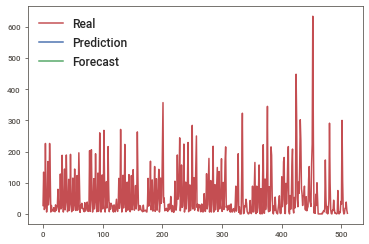

In [ ]:
#fit, predict and forecast cnn with best params
timesteps=6
batch_size=7
epochs=200

x_count, y_count = to_supervised_count(df, timesteps)
x_meters, y_meters = to_supervised_meters(df, timesteps)
x_delay, y_delay = to_supervised_delay(df, timesteps)
print("Training shape:", x_count.shape)
print("Training labels shape:", y_count.shape)

#Time Series Cross Validator
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(x_count): train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets

X_count_train, y_count_train = x_count[train_idx], y_count[train_idx]
X_count_val, y_count_val = x_count[val_idx], y_count[val_idx]
X_count_test, y_count_test = x_count[test_index], y_count[test_index]

X_meters_train, y_meters_train = x_meters[train_idx], y_meters[train_idx]
X_meters_val, y_meters_val = x_meters[val_idx], y_meters[val_idx]
X_meters_test, y_meters_test = x_meters[test_index], y_meters[test_index]

X_delay_train, y_delay_train = x_delay[train_idx], y_delay[train_idx]
X_delay_val, y_delay_val = x_delay[val_idx], y_delay[val_idx]
X_delay_test, y_delay_test = x_delay[test_index], y_delay[test_index]

cnn_count = build_cnn(timesteps)
cnn_count, hist_cnn_count, loss_cnn_count = fit(cnn_count,X_count_train, y_count_train, X_count_val, y_count_val, X_count_test, y_count_test, epochs, batch_size) 

cnn_delay = build_cnn(timesteps)
cnn_delay, hist_cnn_delay, loss_cnn_delay = fit(cnn_delay,X_delay_train, y_delay_train, X_delay_val, y_delay_val, X_delay_test, y_delay_test, epochs, batch_size) 

cnn_meters = build_cnn(timesteps)
cnn_meters, hist_cnn_meters, loss_cnn_meters = fit(cnn_meters,X_meters_train, y_meters_train, X_meters_val, y_meters_val, X_meters_test, y_meters_test, epochs, batch_size) 

y_count_pred = predict(cnn_count, X_count_test) 
y_meters_pred = predict(cnn_meters, X_meters_test)
y_delay_pred = predict(cnn_delay, X_delay_test) 

next_days=forecast(cnn_count,cnn_meters,cnn_delay,x_count, x_meters, x_delay,timesteps)

scale = MinMaxScaler(feature_range=(0,1))
scale.min_, scale.scale_=scaler.min_[0],scaler.scale_[0]


y_count_test = scale.inverse_transform(y_count_test)
y_count_pred = scale.inverse_transform(y_count_pred)
next_days = scale.inverse_transform(next_days)

plt.plot(range(len(y_count_test)),y_count_test,"r-", label="Real")
plt.plot(range(len(y_count_pred)), y_count_pred, "b-",label="Prediction")
plt.plot(range(len(y_count_pred),len(y_count_pred)+len(next_days)), next_days, "g-",label="Forecast")
plt.legend(fontsize=12)
plt.savefig('cnn_graph')
plt.show()

Para terminar apresentamos a evolução da performance dos 3 modelos ao longo do seu treino

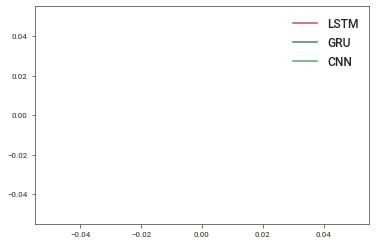

In [ ]:
plt.plot(range(len(hist_lstm_count.history['mae'])),hist_lstm_count.history['mae'],"r-", label="LSTM")
plt.plot(range(len(hist_gru_count.history['mae'])),hist_gru_count.history['mae'], "b-",label="GRU")
plt.plot(range(len(hist_cnn_count.history['mae'])),hist_cnn_count.history['mae'], "g-",label="CNN")
plt.legend(fontsize=12)
plt.savefig('results_mae')
plt.show()